# CAT VS DOG

#Step 1 — Download & inspect dataset (Colab + Kaggle)



Install Kaggle and upload your kaggle.json (API token).
Run this cell, upload your kaggle.json when prompted:

In [ ]:
import os, shutil
from google.colab import files

# Make directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Upload kaggle.json
uploaded = files.upload()

# Move kaggle.json to the correct path
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Fix file permissions
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("Kaggle API token installed successfully!")


Saving kaggle.json to kaggle.json
Kaggle API token installed successfully!


## Download and unzip the dataset from Kaggle:

In [ ]:
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
License(s): apache-2.0
 99% 766M/775M [00:07<00:00, 259MB/s]
100% 775M/775M [00:07<00:00, 113MB/s]


## List files and inspect folder structure:

In [ ]:
# 4. Inspect dataset files and folders
import os, glob, pandas as pd

root = '/content/PetImages'  # dataset path in Colab
print("Listing files/folders in /content (first 200 entries):")
for i, p in enumerate(sorted(os.listdir(root))):
    if i < 200:
        print("-", p)

# Try to find common image folders inside extracted dataset
possible_dirs = []
for dirpath, dirnames, filenames in os.walk(root):
    # limit depth and size of printing
    if any(fname.lower().endswith(('.jpg','.jpeg','.png')) for fname in filenames):
        possible_dirs.append(dirpath)

print("\nDirectories containing images (sample):")
for d in possible_dirs[:10]:
    print("-", d)


Listing files/folders in /content (first 200 entries):
- Cat
- Dog

Directories containing images (sample):
- /content/PetImages/Dog
- /content/PetImages/Cat


## Count images per folder and show a few sample images (visual check):

Image-containing directories found (count): 2
/content/PetImages/Dog: 12499 images
/content/PetImages/Cat: 12499 images

Displaying up to 4 sample images:


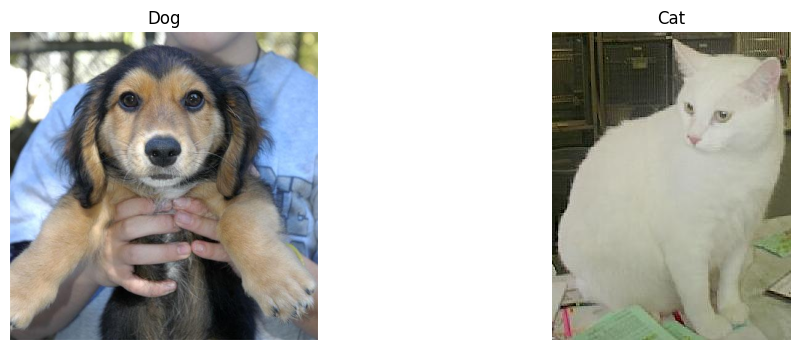

In [ ]:
# 5. Count images & display a sample from each class
import matplotlib.pyplot as plt
from PIL import Image
import random

# find folders that look like classes (have images)
image_dirs = [d for d in possible_dirs if len(os.listdir(d))>0]
# we'll pick top-level dirs that likely contain 'cats' or 'dogs'
print("Image-containing directories found (count):", len(image_dirs))

# Create dictionary of counts
counts = {}
for d in image_dirs:
    imgs = [f for f in os.listdir(d) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    counts[d] = len(imgs)

# show counts (top 20)
for d, c in sorted(counts.items(), key=lambda x: -x[1])[:20]:
    print(f"{d}: {c} images")

# Display random sample images (up to 4)
samples = []
for d, c in list(counts.items())[:4]:
    imgs = [os.path.join(d,f) for f in os.listdir(d) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if imgs:
        samples.append(imgs[random.randrange(len(imgs))])

print("\nDisplaying up to 4 sample images:")
plt.figure(figsize=(12,4))
for i,p in enumerate(samples):
    try:
        img = Image.open(p).convert('RGB')
        plt.subplot(1, len(samples), i+1)
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(p)))
        plt.axis('off')
    except Exception as e:
        print("Failed to open", p, e)
plt.show()


## (Optional quick check) Print image sizes distribution to see if resizing will be needed:

In [ ]:
# 6. Image size distribution (sample up to 200 images to speed up)
from collections import Counter
sizes = Counter()
checked = 0
for d in image_dirs:
    for fname in os.listdir(d):
        if fname.lower().endswith(('.jpg','.jpeg','.png')):
            try:
                im = Image.open(os.path.join(d,fname))
                sizes[im.size] += 1
            except:
                pass
            checked += 1
            if checked >= 200:
                break
    if checked >= 200:
        break

print("Sample image size counts (width, height):")
for s,c in sizes.most_common():
    print(s, c)


Sample image size counts (width, height):
(500, 375) 45
(375, 500) 6
(500, 333) 3
(320, 240) 3
(500, 332) 2
(399, 500) 2
(500, 433) 2
(500, 334) 2
(300, 400) 2
(500, 408) 2
(500, 343) 2
(500, 356) 2
(500, 358) 2
(448, 336) 2
(500, 400) 2
(363, 306) 1
(150, 113) 1
(337, 500) 1
(300, 230) 1
(350, 262) 1
(400, 300) 1
(387, 500) 1
(500, 446) 1
(500, 362) 1
(498, 344) 1
(500, 456) 1
(60, 94) 1
(337, 307) 1
(341, 317) 1
(200, 222) 1
(299, 291) 1
(289, 303) 1
(418, 358) 1
(410, 500) 1
(487, 500) 1
(271, 211) 1
(257, 228) 1
(150, 112) 1
(301, 337) 1
(381, 500) 1
(500, 485) 1
(334, 500) 1
(277, 291) 1
(306, 500) 1
(250, 241) 1
(500, 394) 1
(500, 496) 1
(291, 429) 1
(395, 370) 1
(500, 347) 1
(443, 234) 1
(395, 500) 1
(464, 500) 1
(171, 186) 1
(200, 200) 1
(350, 263) 1
(320, 272) 1
(412, 500) 1
(318, 500) 1
(350, 356) 1
(500, 460) 1
(480, 360) 1
(331, 500) 1
(146, 116) 1
(300, 451) 1
(479, 430) 1
(421, 500) 1
(96, 72) 1
(350, 321) 1
(400, 405) 1
(318, 443) 1
(371, 500) 1
(500, 385) 1
(142, 93) 1


#Step 2 — Preprocessing + Train/Validation/Test Split + Data Augmentation

We’ll use TensorFlow/Keras ImageDataGenerator to:

Split into train/validation/test

Apply data augmentation (rotation, flip, zoom, brightness, etc.)

Normalize pixel values (0–1)

✅ What this does:

Resizes all images to 128×128.

Applies augmentation only to training data.

Splits dataset into 80% training / 20% validation.

Normalizes pixel values (0–1).

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# ------------------------------
# Paths (adjust if dataset unzipped differently)
# ------------------------------
# Example: if dataset has two folders: 'cats' and 'dogs' inside a folder
dataset_dir = "/content/PetImages"  # <- change to your dataset folder name

# ------------------------------
# Image parameters
# ------------------------------
img_size = (128, 128)   # resize images
batch_size = 32

# ------------------------------
# Data Augmentation for training
# ------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Only rescaling for validation & test
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# ------------------------------
# Train & Validation Generators
# ------------------------------
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    shuffle=True
)

# ------------------------------
# OPTIONAL: Separate Test Split
# ------------------------------
# If dataset has no explicit "test" folder, we can split validation into two parts later.
# For now, we keep train/validation.


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


# Step 3 — Build CNN Model (with Conv Layers, Pooling, Dropout, BatchNorm)

We’ll design a moderately deep CNN for Cats vs Dogs classification.


✅ What this model has:

3 convolutional blocks → deeper spatial features.

MaxPooling layers → reduce dimensions.

Dropout → prevent overfitting.

BatchNormalization → stabilize training.

Dense layer + sigmoid → binary classification (cats vs dogs).

In [ ]:
from tensorflow.keras import layers, models

# ------------------------------
# CNN Model
# ------------------------------
model = models.Sequential([
    # 1st Convolution Block
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # 2nd Convolution Block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # 3rd Convolution Block
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    # Flatten + Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output Layer (binary classification: cat vs dog)
    layers.Dense(1, activation='sigmoid')
])

# ------------------------------
# Compile Model
# ------------------------------
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,209 (24.86 MB)

 Trainable params: 6,517,249 (24.86 MB)

 Non-trainable params: 960 (3.75 KB)

# Step 4 — Train the CNN (with Early Stopping & Model Checkpointing)

This step will:

Train the CNN on train/validation data.

Use EarlyStopping (stop when validation accuracy stops improving).

Save the best model weights with ModelCheckpoint.

📊 What this does:

Trains for up to 25 epochs (but may stop early if no improvement).

Automatically reduces learning rate when stuck.

Saves the best model as best_cnn_model.h5.

Restores best weights at the end.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ------------------------------
# Callbacks
# ------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,        # stop if no improvement for 5 epochs
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_cnn_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# ------------------------------
# Training
# ------------------------------
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
482/625 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.5991 - loss: 0.8450

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6041 - loss: 0.8182
Epoch 1: val_accuracy improved from -inf to 0.50460, saving model to best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 207ms/step - accuracy: 0.6041 - loss: 0.8180 - val_accuracy: 0.5046 - val_loss: 1.0729 - learning_rate: 0.0010
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6813 - loss: 0.5963
Epoch 2: val_accuracy improved from 0.50460 to 0.67847, saving model to best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 128s 204ms/step - accuracy: 0.6814 - loss: 0.5963 - val_accuracy: 0.6785 - val_loss: 0.5947 - learning_rate: 0.0010
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7329 - loss: 0.5259
Epoch 3: val_accuracy improved from 0.67847 to 0.73830, saving model to best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.7329 - loss: 0.5259 - val_accuracy: 0.7383 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7574 - loss: 0.4983
Epoch 4: val_accuracy improved from 0.73830 to 0.77771, saving model to best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - accuracy: 0.7574 - loss: 0.4983 - val_accuracy: 0.7777 - val_loss: 0.4703 - learning_rate: 0.0010
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7720 - loss: 0.4719
Epoch 5: val_accuracy did not improve from 0.77771
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.7720 - loss: 0.4719 - val_accuracy: 0.7195 - val_loss: 0.5555 - learning_rate: 0.0010
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7912 - loss: 0.4489
Epoch 6: val_accuracy did not improve from 0.77771
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.7912 - loss: 0.4489 - val_accuracy: 0.5834 - val_loss: 1.0511 - learning_rate: 0.0010
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8046 - loss: 0.4242
Epoch 7: val_accuracy did not improve from 0.77771

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
625/625 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - accuracy: 0.8046 - loss

625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.8332 - loss: 0.3730 - val_accuracy: 0.8561 - val_loss: 0.3328 - learning_rate: 2.0000e-04
Epoch 9/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8385 - loss: 0.3649
Epoch 9: val_accuracy did not improve from 0.85614
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.8385 - loss: 0.3649 - val_accuracy: 0.8541 - val_loss: 0.3541 - learning_rate: 2.0000e-04
Epoch 10/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8503 - loss: 0.3488
Epoch 10: val_accuracy did not improve from 0.85614
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 201ms/step - accuracy: 0.8503 - loss: 0.3488 - val_accuracy: 0.8553 - val_loss: 0.3319 - learning_rate: 2.0000e-04
Epoch 11/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8417 - loss: 0.3495
Epoch 11: val_accuracy improved from 0.85614 to 0.86315, saving model to best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 201ms/step - accuracy: 0.8417 - loss: 0.3495 - val_accuracy: 0.8631 - val_loss: 0.3190 - learning_rate: 2.0000e-04
Epoch 12/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8533 - loss: 0.3331
Epoch 12: val_accuracy did not improve from 0.86315
625/625 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - accuracy: 0.8533 - loss: 0.3331 - val_accuracy: 0.8333 - val_loss: 0.3723 - learning_rate: 2.0000e-04
Epoch 13/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8556 - loss: 0.3254
Epoch 13: val_accuracy did not improve from 0.86315
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.8556 - loss: 0.3254 - val_accuracy: 0.8517 - val_loss: 0.3670 - learning_rate: 2.0000e-04
Epoch 14/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8579 - loss: 0.3217
Epoch 14: val_accuracy improved from 0.86315 to 0.87355, saving model to best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.8579 - loss: 0.3217 - val_accuracy: 0.8735 - val_loss: 0.2982 - learning_rate: 2.0000e-04
Epoch 15/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8604 - loss: 0.3231
Epoch 15: val_accuracy did not improve from 0.87355
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 201ms/step - accuracy: 0.8604 - loss: 0.3231 - val_accuracy: 0.8593 - val_loss: 0.3334 - learning_rate: 2.0000e-04
Epoch 16/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8626 - loss: 0.3154
Epoch 16: val_accuracy improved from 0.87355 to 0.88055, saving model to best_cnn_model.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 204ms/step - accuracy: 0.8627 - loss: 0.3154 - val_accuracy: 0.8806 - val_loss: 0.2777 - learning_rate: 2.0000e-04
Epoch 17/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8628 - loss: 0.3205
Epoch 17: val_accuracy did not improve from 0.88055
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.8628 - loss: 0.3205 - val_accuracy: 0.8735 - val_loss: 0.2908 - learning_rate: 2.0000e-04
Epoch 18/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8648 - loss: 0.3074
Epoch 18: val_accuracy did not improve from 0.88055
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.8648 - loss: 0.3074 - val_accuracy: 0.8701 - val_loss: 0.3072 - learning_rate: 2.0000e-04
Epoch 19/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8614 - loss: 0.3077
Epoch 19: val_accuracy did not improve from 0.88055

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accu

625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 201ms/step - accuracy: 0.8748 - loss: 0.2922 - val_accuracy: 0.8868 - val_loss: 0.2700 - learning_rate: 4.0000e-05
Epoch 21/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8753 - loss: 0.2904
Epoch 21: val_accuracy did not improve from 0.88675
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.8753 - loss: 0.2904 - val_accuracy: 0.8784 - val_loss: 0.2929 - learning_rate: 4.0000e-05
Epoch 22/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8729 - loss: 0.2924
Epoch 22: val_accuracy did not improve from 0.88675
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.8729 - loss: 0.2924 - val_accuracy: 0.8848 - val_loss: 0.2716 - learning_rate: 4.0000e-05
Epoch 23/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8768 - loss: 0.2886
Epoch 23: val_accuracy did not improve from 0.88675

Epoch 23: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 199ms/step - accur

# 🔹 Step 5 — Evaluate Model + Visualize Results + Confusion Matrix

This step will:

Plot training vs validation accuracy/loss curves.

Evaluate final accuracy on the validation set.

Show a confusion matrix with predictions.

Display a few sample predictions (cat/dog).


✅ What you’ll get:

Graphs: Accuracy & loss curves across epochs.

Validation Accuracy (final model performance).

Confusion Matrix: See where cats/dogs are misclassified.

Classification Report: Precision, Recall, F1-score.

Sample Predictions: 6 random images with predicted vs actual labels.

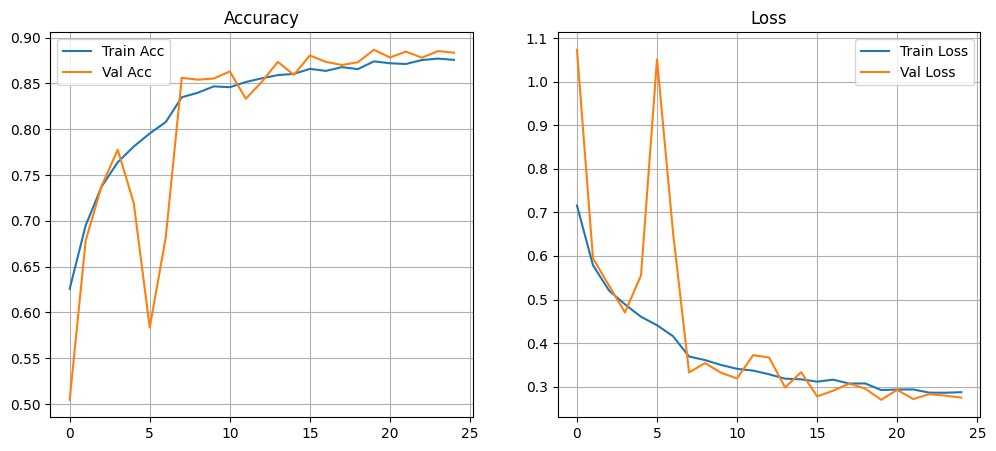

157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 186ms/step - accuracy: 0.8886 - loss: 0.2667

✅ Validation Accuracy: 0.8854
✅ Validation Loss: 0.2784
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step


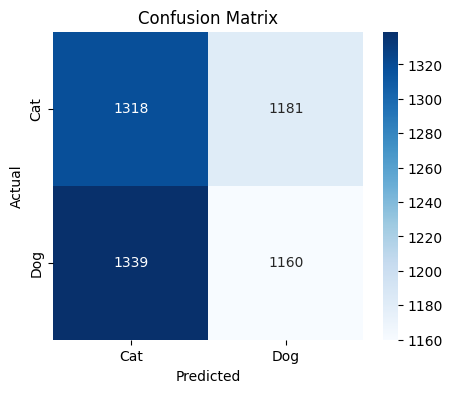


Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      0.53      0.51      2499
         Dog       0.50      0.46      0.48      2499

    accuracy                           0.50      4998
   macro avg       0.50      0.50      0.50      4998
weighted avg       0.50      0.50      0.50      4998

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


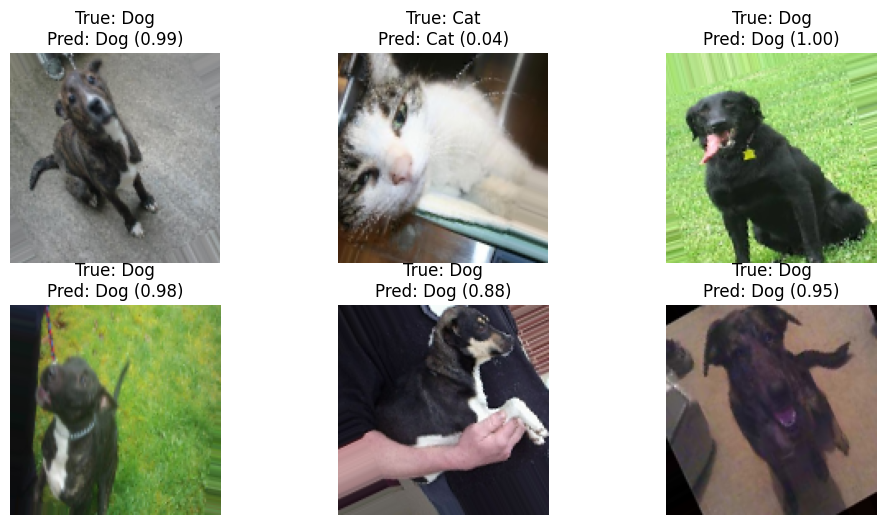

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ------------------------------
# 1. Plot Training Curves
# ------------------------------
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.grid(); plt.title("Accuracy")

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.grid(); plt.title("Loss")

plt.show()

# ------------------------------
# 2. Evaluate Final Model
# ------------------------------
val_loss, val_acc = model.evaluate(val_generator)
print(f"\n✅ Validation Accuracy: {val_acc:.4f}")
print(f"✅ Validation Loss: {val_loss:.4f}")

# ------------------------------
# 3. Confusion Matrix
# ------------------------------
# Get true labels & predictions
val_generator.reset()
y_true = val_generator.classes
y_pred = (model.predict(val_generator) > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat","Dog"], yticklabels=["Cat","Dog"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat","Dog"]))

# ------------------------------
# 4. Show Sample Predictions
# ------------------------------
import random
from tensorflow.keras.preprocessing import image

sample_images, sample_labels = next(val_generator)

plt.figure(figsize=(12,6))
for i in range(6):
    idx = random.randint(0, len(sample_images)-1)
    img = sample_images[idx]
    true_label = "Dog" if sample_labels[idx] == 1 else "Cat"
    pred_prob = model.predict(img[np.newaxis,...])[0][0]
    pred_label = "Dog" if pred_prob > 0.5 else "Cat"

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})")

plt.show()


#🔹 Step 6 — Save, Load & Test on Custom Images

This step will let you:

Save your trained CNN model.

Load it later without retraining.

Upload your own cat/dog images in Colab and get predictions.

In [ ]:
from tensorflow.keras.models import load_model

# Save the trained model
model.save("cats_vs_dogs_cnn.h5")
print("✅ Model saved as cats_vs_dogs_cnn.h5")

# Load model later (for inference or deployment)
loaded_model = load_model("cats_vs_dogs_cnn.h5")
print("✅ Model loaded successfully")


✅ Model saved as cats_vs_dogs_cnn.h5


✅ Model loaded successfully


# 📌 Code (Test on Your Own Images)

Saving dogii.jpeg to dogii.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Image: dogii.jpeg
Prediction: Dog 🐶 (Confidence: 0.99)


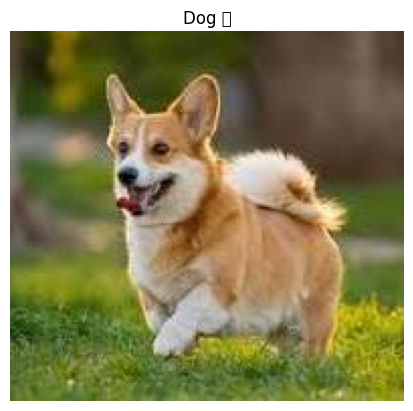

In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image

# Upload custom image(s)
uploaded = files.upload()

for fn in uploaded.keys():
    # Load image
    img_path = fn
    img = image.load_img(img_path, target_size=(128, 128))  # resize same as training
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Prediction
    pred_prob = loaded_model.predict(img_array)[0][0]
    pred_label = "Dog 🐶" if pred_prob > 0.5 else "Cat 🐱"

    print(f"\nImage: {fn}")
    print(f"Prediction: {pred_label} (Confidence: {pred_prob:.2f})")

    # Show image
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(pred_label)
    plt.show()
